In [3]:
# ============================================================
# 0. Imports & Config
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

import xgboost as xgb  
import lightgbm as lgb 

# 경고 무시
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")

DATA_PATH = Path("../data")   # 필요하면 "../data" 로 바꿔

train_df = (
    pd.read_csv(DATA_PATH / "train.csv")
    .sort_values("date_id")
    .reset_index(drop=True)
)

print("Train shape:", train_df.shape)
train_df.head()


Train shape: (9021, 98)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [4]:
# ============================================================
# 2. Competition-like Metric & Backtest Helpers
# ============================================================

MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

class ParticipantVisibleError(Exception):
    pass

def score_metric(solution: pd.DataFrame, positions: np.ndarray) -> float:
    """
    Competition metric의 로컬 버전.
    solution: train_df 일부 (forward_returns, risk_free_rate 포함)
    positions: 같은 길이의 [0, 2] 포지션 벡터
    """
    solution = solution.copy()
    solution["position"] = positions

    if solution["position"].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f"Position exceeds maximum of {MAX_INVESTMENT}")
    if solution["position"].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f"Position below minimum of {MIN_INVESTMENT}")

    # 전략 수익
    solution["strategy_returns"] = (
        solution["risk_free_rate"] * (1 - solution["position"])
        + solution["position"] * solution["forward_returns"]
    )

    strat_excess = solution["strategy_returns"] - solution["risk_free_rate"]
    ex_cum = (1 + strat_excess).prod()
    mean_ex = ex_cum ** (1 / len(solution)) - 1
    std = solution["strategy_returns"].std()

    trading_days = 252
    if std == 0:
        return 0.0
    sharpe = mean_ex / std * np.sqrt(trading_days)
    strat_vol = float(std * np.sqrt(trading_days) * 100)

    # 마켓 기준
    mkt_excess = solution["forward_returns"] - solution["risk_free_rate"]
    mkt_ex_cum = (1 + mkt_excess).prod()
    mkt_mean_ex = mkt_ex_cum ** (1 / len(solution)) - 1
    mkt_std = solution["forward_returns"].std()
    mkt_vol = float(mkt_std * np.sqrt(trading_days) * 100)

    excess_vol = max(0, strat_vol / mkt_vol - 1.2) if mkt_vol > 0 else 0
    vol_penalty = 1 + excess_vol

    return_gap = max(0, (mkt_mean_ex - mean_ex) * 100 * trading_days)
    return_penalty = 1 + (return_gap**2) / 100

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return float(min(adjusted_sharpe, 1_000_000))


def make_equity_curve(returns: pd.Series) -> pd.Series:
    return (1 + returns).cumprod()


def compute_drawdown(cum: pd.Series) -> pd.Series:
    peak = cum.cummax()
    dd = cum / peak - 1.0
    return dd * 100  # pct


In [5]:
# ============================================================
# 3. Advanced Feature Engineering
# ============================================================

TARGET = "market_forward_excess_returns"

# 원시 feature 리스트 (PCA용) - 타겟 / 수익 관련 컬럼 제외
RAW_FEATURE_COLS = [
    c for c in train_df.columns
    if c not in ["forward_returns", "risk_free_rate", "market_forward_excess_returns"]
       and not c.startswith("Unnamed")
]

def add_trend_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Price & momentum 기반 trend strength.
    M4, P9, P10 정도를 대표 지수라고 가정.
    """
    out = df.copy()

    for col in ["M4", "P9", "P10"]:
        if col not in out.columns:
            continue
        roll_mean_21 = out[col].rolling(21, min_periods=10).mean()
        roll_std_21  = out[col].rolling(21, min_periods=10).std()
        out[f"{col}_trend_strength"] = (out[col] - roll_mean_21) / (roll_std_21 + 1e-8)

        roll_mean_63 = out[col].rolling(63, min_periods=20).mean()
        roll_std_63  = out[col].rolling(63, min_periods=20).std()
        out[f"{col}_trend_strength_long"] = (out[col] - roll_mean_63) / (roll_std_63 + 1e-8)

    return out


def add_vol_regime(df: pd.DataFrame) -> pd.DataFrame:
    """V2 기반 변동성 레짐"""
    out = df.copy()
    if "V2" in out.columns:
        v2_roll_mean_63 = out["V2"].rolling(63, min_periods=20).mean()
        v2_roll_std_63  = out["V2"].rolling(63, min_periods=20).std()
        out["V2_z63"] = (out["V2"] - v2_roll_mean_63) / (v2_roll_std_63 + 1e-8)
        out["vol_regime"] = (out["V2_z63"] > 2.0).astype(int)
    else:
        out["vol_regime"] = 0
    return out


def add_macro_shock(df: pd.DataFrame) -> pd.DataFrame:
    """
    E16 (macro surprise proxy) 기반 shock indicator
    """
    out = df.copy()
    if "E16" in out.columns:
        e16_roll_mean_63 = out["E16"].rolling(63, min_periods=20).mean()
        e16_roll_std_63  = out["E16"].rolling(63, min_periods=20).std()
        out["E16_z63"] = (out["E16"] - e16_roll_mean_63) / (e16_roll_std_63 + 1e-8)
        out["macro_shock"] = (out["E16_z63"] > 1.5).astype(int)
    else:
        out["macro_shock"] = 0
    return out


def add_yield_curve(df: pd.DataFrame) -> pd.DataFrame:
    """금리 스프레드 (I5 - I1) 및 z-score"""
    out = df.copy()
    if "I5" in out.columns and "I1" in out.columns:
        out["yield_curve"] = out["I5"] - out["I1"]
        yc_roll_mean_63 = out["yield_curve"].rolling(63, min_periods=20).mean()
        yc_roll_std_63  = out["yield_curve"].rolling(63, min_periods=20).std()
        out["yield_curve_z"] = (out["yield_curve"] - yc_roll_mean_63) / (yc_roll_std_63 + 1e-8)
    else:
        out["yield_curve"] = 0.0
        out["yield_curve_z"] = 0.0
    return out


def add_sentiment_features(df: pd.DataFrame) -> pd.DataFrame:
    """Sentiment level + change"""
    out = df.copy()
    for col in ["S1", "S2"]:
        if col in out.columns:
            out[f"{col}_chg_1"] = out[col].diff(1)
            out[f"{col}_chg_5"] = out[col].diff(5)
    return out


def add_lag_rolling_core(df: pd.DataFrame) -> pd.DataFrame:
    """
    핵심 factor 몇 개에 대해서만 lag / rolling 추가 (과도한 차원 폭발 방지).
    """
    out = df.copy()
    core_cols = ["M4", "P9", "P10", "V2", "E16", "yield_curve", TARGET]

    for col in core_cols:
        if col not in out.columns:
            continue
        # lag
        for lag in [1, 5, 10, 21, 63]:
            out[f"{col}_lag_{lag}"] = out[col].shift(lag)
        # rolling mean / std
        for wnd in [5, 21, 63]:
            roll = out[col].rolling(wnd, min_periods=int(wnd/2))
            out[f"{col}_roll_mean_{wnd}"] = roll.mean()
            out[f"{col}_roll_std_{wnd}"] = roll.std()
    return out


def add_pca_factors(df: pd.DataFrame, n_components: int = 5):
    """
    전체 Raw feature를 PCA factor로 요약.
    타겟/리턴 정보는 제외한 뒤 z-score 후 PCA.
    """
    raw = df[RAW_FEATURE_COLS].copy()
    raw = raw.fillna(method="ffill").fillna(method="bfill")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(raw)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(
        X_pca,
        columns=[f"pca_factor_{i}" for i in range(n_components)],
        index=df.index,
    )
    return pca_df, pca, scaler


def build_feature_table(df: pd.DataFrame):
    """
    위에서 정의한 모든 FE를 순서대로 적용해서
    최종 feature table(X)과 target(y)을 반환.
    """
    fe = df.copy()

    fe = add_trend_features(fe)
    fe = add_vol_regime(fe)
    fe = add_macro_shock(fe)
    fe = add_yield_curve(fe)
    fe = add_sentiment_features(fe)
    fe = add_lag_rolling_core(fe)

    # PCA factors (raw 정보 압축)
    pca_df, pca_model, pca_scaler = add_pca_factors(fe)
    fe = pd.concat([fe, pca_df], axis=1)

    # NaN 처리
    fe = fe.fillna(method="ffill").fillna(method="bfill")

    # feature / target 분리
    feats = [
        c for c in fe.columns
        if c not in [
            TARGET, "forward_returns", "risk_free_rate",
            "market_forward_excess_returns"
        ]
    ]
    X = fe[feats].copy()
    y = fe[TARGET].copy()

    return X, y, feats, pca_model, pca_scaler


In [6]:
# ============================================================
# 4. Prediction → Position Mapping
# ============================================================

def preds_to_positions(preds: np.ndarray) -> np.ndarray:
    """
    회귀 예측값을 [0, 2] 포지션으로 매핑.
    - 낮은 quantile: 0
    - 중간: 0 ~ 1 사이 선형
    - 상위 quantile: 1 ~ 2 사이 선형
    """
    preds = np.asarray(preds, dtype=float)

    q_low, q_mid, q_high = np.quantile(preds, [0.2, 0.5, 0.8])

    positions = np.zeros_like(preds)

    # 중간 구간: 0 ~ 1
    mid_mask = (preds > q_low) & (preds <= q_mid)
    positions[mid_mask] = (preds[mid_mask] - q_low) / (q_mid - q_low + 1e-8) * 1.0

    # 상위 구간: 1 ~ 2
    high_mask = (preds > q_mid) & (preds <= q_high)
    positions[high_mask] = 1.0 + (preds[high_mask] - q_mid) / (q_high - q_mid + 1e-8) * 1.0

    # 최상위 꼬리: 2 고정
    tail_mask = preds > q_high
    positions[tail_mask] = 2.0

    positions = np.clip(positions, 0.0, 2.0)
    return positions


In [7]:
# ============================================================
# 5. Build Features
# ============================================================
X, y, feature_names, pca_model, pca_scaler = build_feature_table(train_df)

print("Final X shape:", X.shape)
print("Target shape :", y.shape)


Final X shape: (9021, 193)
Target shape : (9021,)


In [10]:
# ============================================================
# 6. TimeSeriesSplit CV with XGBoost + LightGBM Ensemble
# ============================================================

tscv = TimeSeriesSplit(n_splits=4)

fold_results = []
val_equity_curves = {}

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # ------------------ XGBoost ------------------
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    xgb_params = {
        "objective": "reg:squarederror",
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 10,
        "lambda": 2.0,
        "alpha": 0.0,
        "seed": 42,
        "eval_metric": "rmse",
    }

    xgb_model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=700,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=False,
    )

    # ------------------ LightGBM ------------------
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    lgb_params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.03,
        "num_leaves": 64,
        "max_depth": -1,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "lambda_l2": 2.0,
        "verbose": -1,
        "seed": 42,
    }

    lgb_model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=800,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=["train", "valid"],
    )

    # ------------------ Predictions & Ensemble ------------------
    xgb_pred = xgb_model.predict(dvalid)
    lgb_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

    # 60% XGB + 40% LGB
    preds = 0.6 * xgb_pred + 0.4 * lgb_pred

    # ------------------ Evaluation ------------------
    pos = preds_to_positions(preds)

    val_slice = train_df.iloc[val_idx].copy()
    score = score_metric(val_slice, pos)

    corr = np.corrcoef(preds, y_val)[0, 1]
    r2 = r2_score(y_val, preds)

    # 백테스트
    strat_ret = val_slice["risk_free_rate"] * (1 - pos) + pos * val_slice["forward_returns"]
    mkt_ret = val_slice["forward_returns"]

    strat_cum = make_equity_curve(strat_ret)
    mkt_cum = make_equity_curve(mkt_ret)
    dd = compute_drawdown(strat_cum)

    fold_results.append({
        "fold": fold,
        "score": score,
        "corr": corr,
        "r2": r2,
    })

    # 마지막 fold는 그래프용으로 저장
    val_equity_curves[fold] = (mkt_cum, strat_cum, dd)

    print(
        f"[Fold {fold}] score={score:.4f} | corr={corr:.4f} | r2={r2:.4f} "
        f"| strat_final={strat_cum.iloc[-1]:.3f} | mkt_final={mkt_cum.iloc[-1]:.3f}"
    )

# 전체 CV 요약
cv_df = pd.DataFrame(fold_results)
print("\n=== CV Summary ===")
print(cv_df)
print(
    f"\nScore mean: {cv_df['score'].mean():.4f} ± {cv_df['score'].std():.4f}\n"
    f"Corr  mean: {cv_df['corr'].mean():.4f} ± {cv_df['corr'].std():.4f}\n"
    f"R2    mean: {cv_df['r2'].mean():.4f} ± {cv_df['r2'].std():.4f}"
)


[Fold 1] score=4.0772 | corr=0.5972 | r2=0.3306 | strat_final=16659.397 | mkt_final=1.521
[Fold 2] score=5.1082 | corr=0.7452 | r2=0.5427 | strat_final=26485.414 | mkt_final=1.424
[Fold 3] score=7.2999 | corr=0.8296 | r2=0.6724 | strat_final=10567.762 | mkt_final=2.670
[Fold 4] score=7.2179 | corr=0.7968 | r2=0.6302 | strat_final=98238.511 | mkt_final=2.731

=== CV Summary ===
   fold     score      corr        r2
0     1  4.077213  0.597216  0.330566
1     2  5.108198  0.745167  0.542693
2     3  7.299860  0.829618  0.672367
3     4  7.217896  0.796778  0.630180

Score mean: 5.9258 ± 1.5962
Corr  mean: 0.7422 ± 0.1027
R2    mean: 0.5440 ± 0.1522


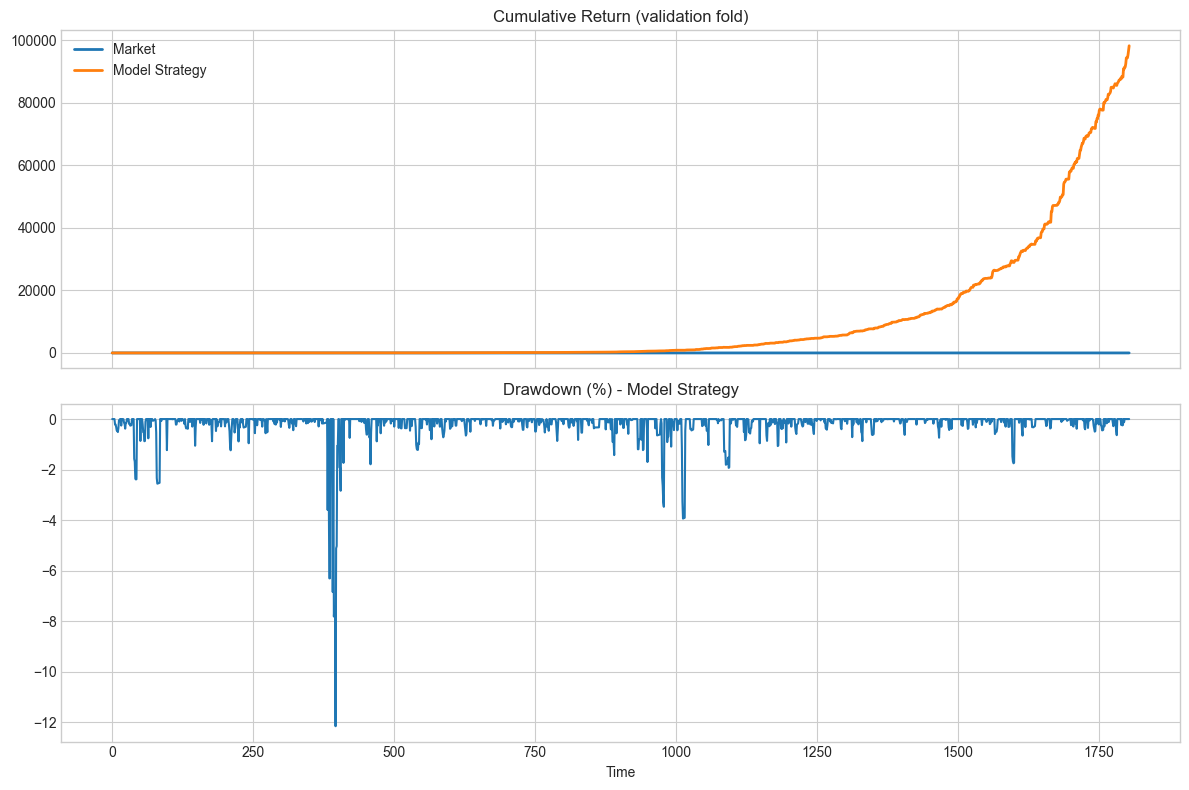

In [11]:
# ============================================================
# 7. Plot last fold equity curve & drawdown
# ============================================================
last_fold = max(val_equity_curves.keys())
mkt_cum, strat_cum, dd = val_equity_curves[last_fold]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(mkt_cum.values, label="Market", lw=2)
axes[0].plot(strat_cum.values, label="Model Strategy", lw=2)
axes[0].set_title("Cumulative Return (validation fold)")
axes[0].legend()

axes[1].plot(dd.values)
axes[1].set_title("Drawdown (%) - Model Strategy")
axes[1].set_xlabel("Time")

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, preds)
rmse = np.sqrt(mse)
corr = np.corrcoef(y_val, preds)[0, 1]

print(f"MSE:  {mse:.8f}")
print(f"RMSE: {rmse:.8f}")
print(f"Corr: {corr:.6f}")


MSE:  0.00004571
RMSE: 0.00676064
Corr: 0.796778


In [13]:
strat_final = strat_cum.iloc[-1]
mkt_final = mkt_cum.iloc[-1]

print(f"Final Strategy Return: {strat_final:.4f}")
print(f"Final Market Return  : {mkt_final:.4f}")
print(f"Strategy / Market Ratio: {strat_final / mkt_final if mkt_final != 0 else np.inf:.4f}")


Final Strategy Return: 98238.5110
Final Market Return  : 2.7309
Strategy / Market Ratio: 35972.9950


In [14]:
print(f"Strategy total return: {(strat_final - 1) * 100:.2f}%")
print(f"Market total return  : {(mkt_final - 1) * 100:.2f}%")


Strategy total return: 9823751.10%
Market total return  : 173.09%


In [15]:
strat_std = strat_ret.std() * np.sqrt(252)
mkt_std = mkt_ret.std() * np.sqrt(252)

print(f"Strategy Vol(ann): {strat_std:.4f}")
print(f"Market   Vol(ann): {mkt_std:.4f}")


Strategy Vol(ann): 0.2151
Market   Vol(ann): 0.1762
